<a href="https://colab.research.google.com/github/eric-castillo05/emotions-wheel-nlp/blob/main/TF-IDF_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

In [3]:
df_train = pl.read_parquet('hf://datasets/Jsevisal/go_emotions_wheel/' + splits['train'])
df_test = pl.read_parquet('hf://datasets/Jsevisal/go_emotions_wheel/' + splits['test'])

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [5]:
def decontract(sentence):
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def removePunctuation(sentence):
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
    sentence = sentence.strip()
    sentence = sentence.replace("\n"," ")
    return sentence

def removeNumber(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in sentence.split() if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmedSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmedSentence += stem
        stemmedSentence += " "
    stemmedSentence = stemmedSentence.strip()
    return stemmedSentence

In [6]:
x_train, y_train = df_train.select('text').to_series().to_list(), df_train.select('labels').to_series().to_list()
x_test, y_test = df_test.select('text').to_series().to_list(), df_test.select('labels').to_series().to_list()

In [7]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
import spacy

In [14]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])

In [8]:
from sklearn.preprocessing import normalize

def spacy_embeddings(texts):
    texts_processed = [decontract(t) for t in texts]
    docs = list(nlp.pipe(texts_processed, batch_size=50))
    vectors = np.array([doc.vector for doc in docs])
    return normalize(vectors, norm='l2')

In [9]:
def custom_preprocess(text):
    text = decontract(text)
    text = removePunctuation(text)
    text = removeNumber(text)
    text = removeStopWords(text)
    # text = stemming(text)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    return ' '.join(lemmas)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [16]:
feature_union = FeatureUnion([
    ("tfidf", TfidfVectorizer(
        preprocessor=custom_preprocess,
        ngram_range=(1, 2),
        max_features=8000,
        norm="l2"
    )),
    ("embeddings", FunctionTransformer(
        spacy_embeddings,
        validate=False
    ))
])

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
x_train = feature_union.fit_transform(x_train)
x_test = feature_union.transform(x_test)

In [19]:
x_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13314518 stored elements and shape (43410, 8300)>

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import cross_val_score

In [21]:
y_train_raw = df_train['labels'].to_list()
y_test_raw = df_test['labels'].to_list()

all_labels_combined = y_train_raw + y_test_raw
all_unique_label_ids = sorted(list(set(item for sublist in all_labels_combined for item in sublist)))

In [22]:
mlb = MultiLabelBinarizer(classes=all_unique_label_ids)
mlb.fit(all_labels_combined)

y_train_multilabel = mlb.transform(y_train_raw)
y_test_multilabel = mlb.transform(y_test_raw)

In [23]:
y_train_multilabel

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [24]:
x_train[0].shape

(1, 8300)

In [25]:
from sklearn.metrics import classification_report

# Log Reg

In [26]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [27]:
lreg = LogisticRegression(multi_class='multinomial', class_weight = 'balanced', solver = 'newton-cg', penalty = 'l2')

In [28]:
from sklearn.multiclass import OneVsRestClassifier

In [29]:
model = OneVsRestClassifier(lreg)

In [30]:
model.fit(x_train, y_train_multilabel)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 multi_class='multinomial',
                                                 solver='newton-cg'))

In [31]:
y_pred = model.predict(x_test)

In [32]:
print(classification_report(y_test_multilabel, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1650
           1       0.21      0.55      0.31       474
           2       0.42      0.84      0.56        98
           3       0.40      0.68      0.50       677
           4       0.34      0.64      0.44       379
           5       0.56      0.76      0.65      1787
           6       0.24      0.53      0.33        83
           7       0.37      0.68      0.48       726
           8       0.28      0.60      0.39       123

   micro avg       0.47      0.73      0.58      5997
   macro avg       0.40      0.68      0.50      5997
weighted avg       0.53      0.73      0.60      5997
 samples avg       0.54      0.74      0.60      5997



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ROC Curve

In [33]:
mlb.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

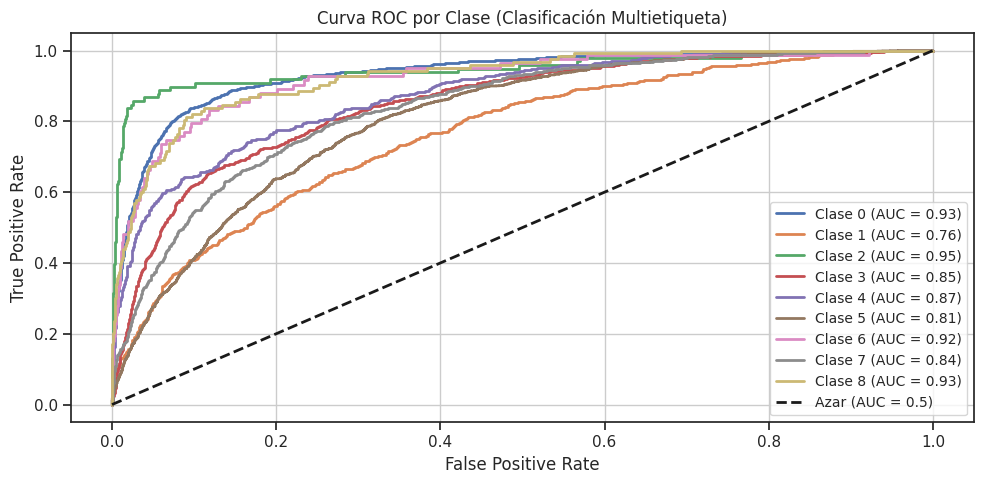

In [34]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc


fpr = dict()
tpr = dict()
roc_auc = dict()
sns.set_theme(style = 'ticks')

y_score = model.predict_proba(x_test)

plt.figure(figsize = (10, 5))
n_classes = y_test_multilabel.shape[1]
temp = []
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_multilabel[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {mlb.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    temp.append([mlb.classes_[i], roc_auc[i]])

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Azar (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC por Clase (Clasificación Multietiqueta)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
temp

[[np.int64(0), np.float64(0.934592630033456)],
 [np.int64(1), np.float64(0.7648997624079853)],
 [np.int64(2), np.float64(0.9468522255965625)],
 [np.int64(3), np.float64(0.8512415455181528)],
 [np.int64(4), np.float64(0.8735406587524932)],
 [np.int64(5), np.float64(0.8082299206110062)],
 [np.int64(6), np.float64(0.921528930091624)],
 [np.int64(7), np.float64(0.8399716255201549)],
 [np.int64(8), np.float64(0.9251569608456267)]]

In [65]:
from sklearn.metrics import f1_score, precision_recall_curve, classification_report

n_classes = y_test_multilabel.shape[1]
optimal_thresholds = {}

for i in range(n_classes):
  class_name = mlb.classes_[i]

  precision, recall, thresholds = precision_recall_curve(y_test_multilabel[:, i], y_score[:, i])

  with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    f1_scores = np.nan_to_num(f1_scores)

  best_idx = np.argmax(f1_scores)
  best_threshold = thresholds[best_idx]
  best_f1 = f1_scores[best_idx]

  y_pred_default = (y_score[:, i] > 0.5).astype(int)
  default_f1 = f1_score(y_test_multilabel[:, i], y_pred_default)

  y_pred_optimized = (y_score[:, i] > best_threshold).astype(int)
  optimized_f1 = f1_score(y_test_multilabel[:, i], y_pred_optimized)

  optimal_thresholds[class_name] = best_threshold

  print(f"Clase {class_name:12} | Threshold: {best_threshold:.3f} | "
        f"F1 default: {default_f1:.3f} | F1 optimizado: {optimized_f1:.3f} | "
        f"Mejora: {optimized_f1 - default_f1:+.3f}")


Clase            0 | Threshold: 0.571 | F1 default: 0.809 | F1 optimizado: 0.815 | Mejora: +0.006
Clase            1 | Threshold: 0.720 | F1 default: 0.307 | F1 optimizado: 0.342 | Mejora: +0.035
Clase            2 | Threshold: 0.787 | F1 default: 0.560 | F1 optimizado: 0.638 | Mejora: +0.078
Clase            3 | Threshold: 0.619 | F1 default: 0.500 | F1 optimizado: 0.539 | Mejora: +0.039
Clase            4 | Threshold: 0.727 | F1 default: 0.442 | F1 optimizado: 0.515 | Mejora: +0.072
Clase            5 | Threshold: 0.459 | F1 default: 0.647 | F1 optimizado: 0.651 | Mejora: +0.005
Clase            6 | Threshold: 0.715 | F1 default: 0.330 | F1 optimizado: 0.406 | Mejora: +0.077
Clase            7 | Threshold: 0.566 | F1 default: 0.478 | F1 optimizado: 0.501 | Mejora: +0.023
Clase            8 | Threshold: 0.920 | F1 default: 0.385 | F1 optimizado: 0.437 | Mejora: +0.051


In [67]:
from sklearn.metrics import hamming_loss, coverage_error

print(f"Hamming Loss: {hamming_loss(y_test_multilabel, y_pred):.3f}")
print(f"Coverage Error: {coverage_error(y_test_multilabel, y_score):.3f}")

Hamming Loss: 0.132
Coverage Error: 2.003


In [75]:
y_pred_optimized = np.zeros_like(y_score)

for i in range(n_classes):
    threshold = optimal_thresholds[mlb.classes_[i]]
    y_pred_optimized[:, i] = (y_score[:, i] > threshold).astype(int)

In [73]:
from sklearn.metrics import hamming_loss, coverage_error

print("Classification Report con umbrales optimizados:")
print(classification_report(y_test_multilabel, y_pred_optimized, target_names=[str(c) for c in mlb.classes_]))

print("Hamming Loss:", hamming_loss(y_test_multilabel, y_pred_optimized))
print("Coverage Error:", coverage_error(y_test_multilabel, y_score))

Classification Report con umbrales optimizados:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1650
           1       0.32      0.37      0.34       474
           2       0.60      0.68      0.64        98
           3       0.48      0.61      0.54       677
           4       0.51      0.51      0.51       379
           5       0.55      0.80      0.65      1787
           6       0.36      0.47      0.41        83
           7       0.41      0.63      0.50       726
           8       0.58      0.35      0.44       123

   micro avg       0.56      0.70      0.62      5997
   macro avg       0.51      0.58      0.54      5997
weighted avg       0.58      0.70      0.62      5997
 samples avg       0.59      0.71      0.62      5997

Hamming Loss: 0.10451855946604427
Coverage Error: 2.0033167495854065


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
print("Exact match ratio (accuracy):", accuracy_score(y_test_multilabel, y_pred_optimized))
print("Micro F1-score:", f1_score(y_test_multilabel, y_pred_optimized, average='micro'))
print("Macro F1-score:", f1_score(y_test_multilabel, y_pred_optimized, average='macro'))

Exact match ratio (accuracy): 0.41625207296849087
Micro F1-score: 0.6203049460766084
Macro F1-score: 0.5381772679470185


# Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, class_weight='balanced'))

In [78]:
model.fit(x_train, y_train_multilabel)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced'))

In [85]:
y_pred_random_forest = model.predict(x_test)

In [86]:
print(classification_report(y_test_multilabel, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.89      0.41      0.56      1650
           1       0.60      0.01      0.01       474
           2       1.00      0.01      0.02        98
           3       0.55      0.02      0.03       677
           4       0.71      0.01      0.03       379
           5       0.68      0.15      0.24      1787
           6       0.00      0.00      0.00        83
           7       0.57      0.01      0.01       726
           8       0.00      0.00      0.00       123

   micro avg       0.81      0.16      0.27      5997
   macro avg       0.56      0.07      0.10      5997
weighted avg       0.69      0.16      0.23      5997
 samples avg       0.18      0.17      0.17      5997



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


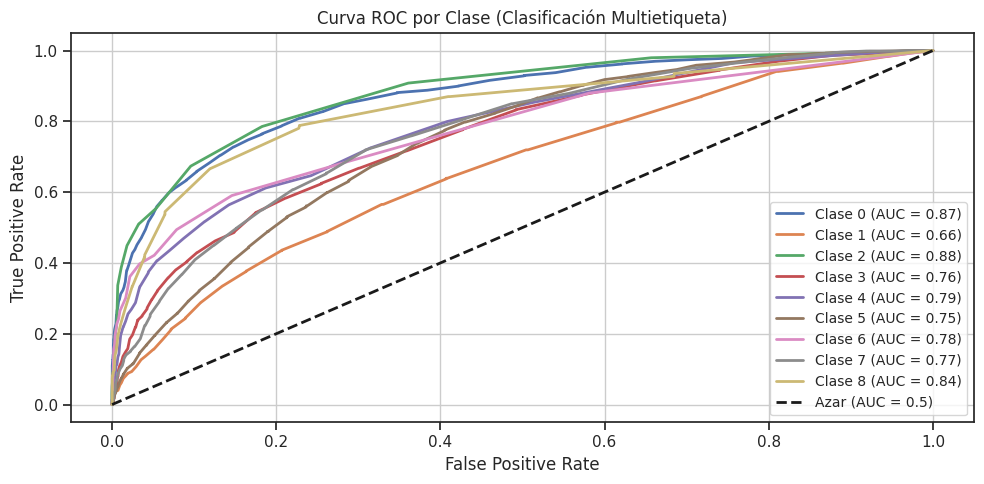

In [88]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc


fpr = dict()
tpr = dict()
roc_auc = dict()
sns.set_theme(style = 'ticks')

y_score = model.predict_proba(x_test)

plt.figure(figsize = (10, 5))
n_classes = y_test_multilabel.shape[1]
temp = []
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_multilabel[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {mlb.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    temp.append([mlb.classes_[i], roc_auc[i]])

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Azar (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC por Clase (Clasificación Multietiqueta)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()